# неХакатон 2021

Чемпионат по машинному обучению на данных МегаФона ([страница мероприятия](https://ii-s-nulya.ru/nehakaton))

## Введение

**Задача:** спрогнозировать объём трафика на каждом слое базовой станции на 12 мес вперед (на каждый месяц).

**Метрика:** модифицированная метрика [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) с областью значений $[0,1]$ (без умножения на 2):

$$\operatorname{SMAPE}\left(y, \hat{y}\right)=\frac{1}{n}\sum\limits_{i=1}^n\frac{\left|y_i-\hat{y}_i\right|}{\left|y_i+\hat{y}_i+10^{-15}\right|}$$

**Решение:** примитивная авторегрессия (3-е место).

### Библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Данные

* [train.csv](https://disk.yandex.ru/d/RNzIbh5o-EKErQ) - набор данных для обучения  
* [test_public.csv](https://disk.yandex.ru/d/0o-B_iCKRnJnDA) - набор данных для предсказания


In [2]:
train = pd.read_csv('train.csv', index_col=0)
test  = pd.read_csv('test_public.csv', index_col=0)

## Анализ временных рядов

Усреднённые временные ряды трафика по всем базовым станциям для каждого слоя.

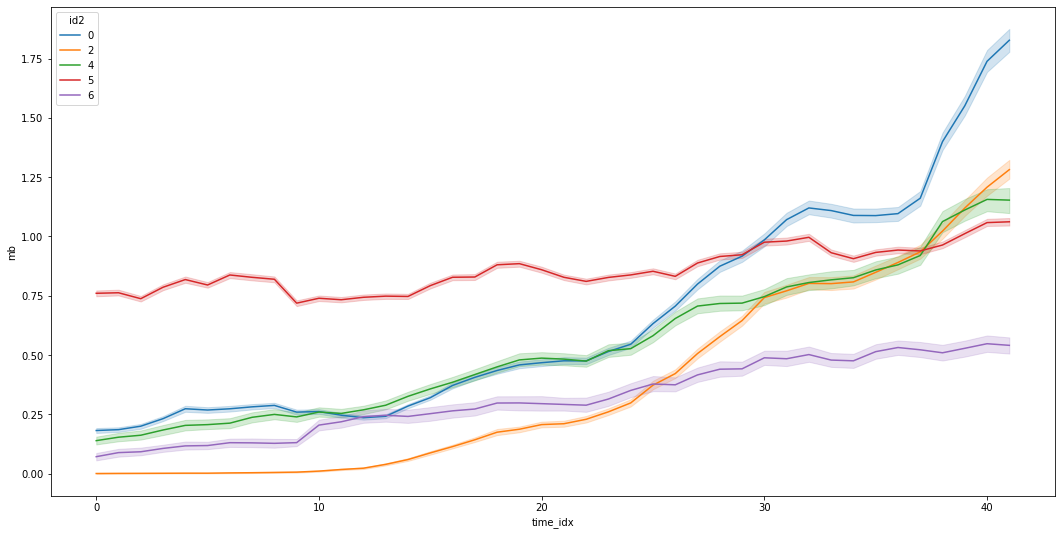

In [3]:
plt.figure(figsize=(18, 9))
sns.lineplot(data=train, x='time_idx', y='mb', hue='id2', palette='tab10')
plt.show()

Датафрейм с временными рядами, расположенными по строкам.

In [4]:
ts = train.groupby(['place_id', 'id2', 'time_idx'])['mb'].mean().unstack(fill_value=0.0)
ts.head()

time_idx            0         1         2         3         4         5   \
place_id id2                                                               
0        5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1        2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         5    0.152166  0.174253  0.166649  0.217806  0.231915  0.221467   
2        5    1.680431  1.742109  1.619486  1.899062  1.838266  1.765845   
3        5    0.259349  0.225909  0.194834  0.243316  0.291960  0.232850   

time_idx            6         7         8         9   ...        32        33  \
place_id id2                                          ...                       
0        5    0.000000  0.000000  0.020294  0.788256  ...  2.179874  2.128282   
1        2    0.000000  0.000000  0.000000  0.000000  ...  0.516567  0.540340   
         5    0.342766  0.348617  0.326309  0.290419  ...  0.279291  0.258732   
2        5    1.890043  1.950265  1.821697  1.750816  ...  2.381274  2.196356   
3        5    0.324981  0.272025  0.224935  0.197894  ...  0.314411  0.232890   

time_idx            34        35        36        37        38        39  \
place_id id2                                                               
0        5    2.184853  2.177352  2.046201  1.933403  2.500697  2.730730   
1        2    0.590695  0.508296  0.627292  0.768456  1.071593  1.205818   
         5    0.236324  0.200879  0.265632  0.294217  0.334794  0.420828   
2        5    2.179641  2.367697  2.427334  2.316888  2.355493  2.220112   
3        5    0.242339  0.279904  0.379978  0.394648  0.342557  0.326659   

time_idx            40        41  
place_id id2                      
0        5    2.786766  2.769272  
1        2    1.302315  1.394586  
         5    0.427913  0.403248  
2        5    2.156451  2.221829  
3        5    0.358086  0.366160  

[5 rows x 42 columns]

Добавление в исходный датасет нового признака `mb_change` - (абсолютное) изменение объёма трафика (для данной станции и слоя) по сравнению с предыдушим месяцем.

In [5]:
train_diff = ts.diff(axis=1).stack()
train_diff.name = 'mb_change'
train = train.join(train_diff, on=['place_id', 'id2', 'time_idx'])

Распределение изменений объёма трафика для каждого слоя

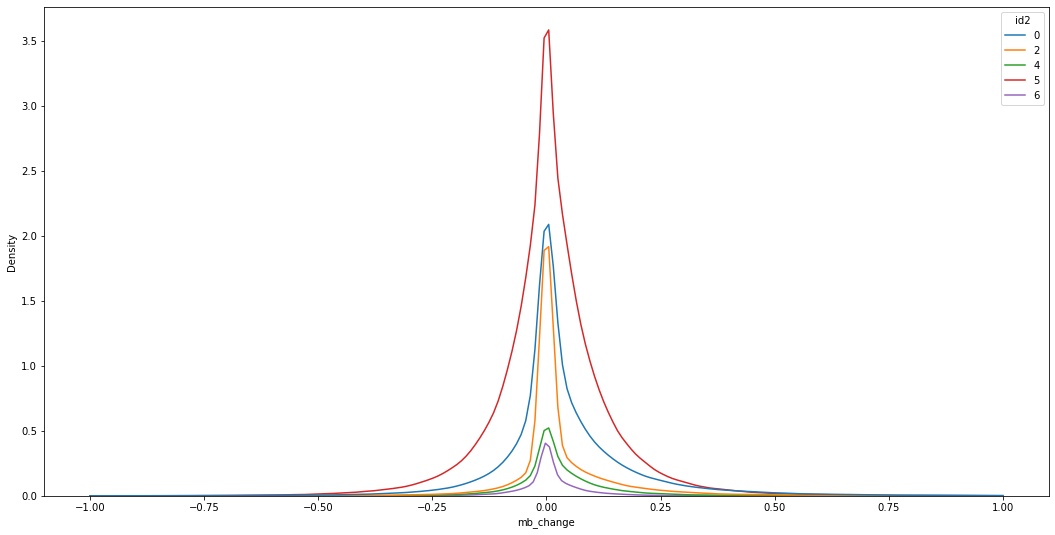

In [6]:
plt.figure(figsize=(18, 9))
sns.kdeplot(data=train, x='mb_change', hue='id2', palette='tab10', clip=(-1, 1))
plt.show()

## Простейшая модель авторегрессии

Данная модель строится на основе следующих **очень грубых** допущений:

Во-первых, предположим, что объём трафика за текущий месяц для заданной базовой станции и для заданного слоя сети зависит от только от аналогичного объёма трафика за предыдущий месяц и от некой случайной величины, которая характеризует изменение трафика:

$$ X_{s,l,t} = X_{s,l,t-1} + \varepsilon_{s,l,t} $$

где

 * $X_{s,l,t}, X_{s,l,t-1}$ - объём трафика за месяц $t$ и $t-1$ для базовой станции $S$ и для слоя сети $L$,  
 * $\varepsilon_{s,l,t}$ - случайное изменение объёма трафика по сравнению с предыдущим месяцем.

Во-вторых, предположим, что для заданной базовой станции и для заданного слоя все случайные изменения объёма трафика $\varepsilon_{s,l,t}$ независимы и одинаково распределены. Следовательно, у всех случайных изменений объёма трафика одинаковое мат. ожидание:

$$ \forall t : E\left[\varepsilon_{s,l,t}\right] = \mu_{s,l}$$

Таким образом, если нам известен объём трафика за текущий месяц, то мы можем оценить мат. ожидание (сделать предсказание) объёма трафика на следующий месяц:

$$ X_{s,l,t+1} = X_{s,l,t} + \varepsilon_{s,l,t+1} $$

$$ E\left[X_{s,l,t+1}\right] = E\left[X_{s,l,t} + \varepsilon_{s,l,t+1}\right] = E\left[X_{s,l,t}\right] + E\left[\varepsilon_{s,l,t+1}\right] = X_{s,l,t} + \mu_{s,l}$$

... и на следующий месяц:

$$ X_{s,l,t+2} = X_{s,l,t+1} + \varepsilon_{s,l,t+2} = X_{s,l,t} + \varepsilon_{s,l,t+1} + \varepsilon_{s,l,t+2}$$

$$ E\left[X_{s,l,t+2}\right] = E\left[X_{s,l,t} + \varepsilon_{s,l,t+1} + \varepsilon_{s,l,t+2}\right] = E\left[X_{s,l,t}\right] + E\left[\varepsilon_{s,l,t+1}\right] + E\left[\varepsilon_{s,l,t+2}\right] = X_{s,l,t} + 2 \cdot \mu_{s,l}$$

... и так далее:

$$ X_{s,l,t+k} = X_{s,l,t+k-1} + \varepsilon_{s,l,t+k} = \ldots = X_{s,l,t} + \varepsilon_{s,l,t+1} + \varepsilon_{s,l,t+2} + \ldots + \varepsilon_{s,l,t+k}$$

$$ E\left[X_{s,l,t+k}\right] = \ldots = X_{s,l,t} + k \cdot \mu_{s,l}$$

Мат. ожидание случайных изменений объёма трафика можно оценить, используюя данные в обучающей выборке.

In [7]:
place_layer_diff_mean = train.groupby(['place_id', 'id2'])['mb_change'].mean()
place_layer_last_value = ts.iloc[:, -1].copy()
place_layer_predict = pd.DataFrame([], index=place_layer_last_value.index)
for i in range(42, 54):
    place_layer_predict[i] = place_layer_last_value + (i - 41) * place_layer_diff_mean
place_layer_predict = place_layer_predict.stack().clip(lower=0.0)
place_layer_predict.name = 'place_layer_mb'

Для базовых станций, которых нет в обучающей выборке, используются усреднённые значения по всем известным станциям.

In [8]:
all_layer_diff_mean = train.groupby(['id2'])['mb_change'].mean()
all_layer_last_value = train.groupby(['id2', 'time_idx'])['mb'].mean().unstack(fill_value=0.0).iloc[:, -1].copy()
all_layer_predict = pd.DataFrame([], index=all_layer_last_value.index)
for i in range(42, 54):
    all_layer_predict[i] = all_layer_last_value + (i - 41) * all_layer_diff_mean
all_layer_predict = all_layer_predict.stack().clip(lower=0.0)
all_layer_predict.name = 'layer_mb'

Объединение предсказаний в один датафрейм

In [9]:
submit = test.join(place_layer_predict, on=['place_id', 'id2', 'time_idx'], how='left')
submit = submit.join(all_layer_predict, on=['id2', 'time_idx'], how='left')
submit['mb'] = submit['place_layer_mb'].where(submit['place_layer_mb'].notna(), submit['layer_mb'])

# safety check
assert submit['mb'].notna().all()
assert (submit['mb'] >= 0.0).all()

In [10]:
submit[['time_idx', 'place_id', 'id2', 'mb']].to_csv('submit.csv', index=False)

Виталий Сильчев

vitaliy.silchev@yandex.ru  
[Telegram](https://t.me/vsilchev)  
[LinkedIn](https://www.linkedin.com/in/vsilchev/)